<a href="https://colab.research.google.com/github/masha-nv/llm/blob/main/Micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(node):
    if node not in nodes:
      nodes.add(node)
      for child in node.prev:
        edges.add((child, node))
        build(child)
  build(root)
  return nodes, edges


def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name=uid, label='{%s | data %.4f | grad %.4f}' % (n.label, n.data, n.grad), shape='record')
    if n.op:
      dot.node(name=(uid + n.op), label=n.op)
      dot.edge(uid+n.op, uid)
  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2))+n2.op)
  return dot

In [3]:
from binascii import Error
class Value:
  def __init__(self, data, children=(), label='', op=''):
    self.data = data
    self.prev = set(children)
    self.label = label
    self.op = op
    self.grad = 0.0
    self._backward = lambda: None

  def __repr__(self):
    out = f'Value(data={self.data})'
    return out

  def __add__(self, other: 'Value'):
    if not isinstance(other, Value) and not isinstance(other, int) and not isinstance(other, float):
      raise Exception('should be an instance of Value class or scaler value of int or float')

    if not isinstance(other, Value):
      other = Value(other)

    out = Value(self.data + other.data, children=(self, other), op='+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward
    return out

  def __radd__(self, other):
    return self + other


  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, children=(self, other), op='*')
    def _backward():
      self.grad += out.grad * other.data
      other.grad += out.grad * self.data

    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self * other

  def tanh(self):
    t = (math.exp(2*self.data) - 1) / (math.exp(2*self.data) + 1)
    out = Value(t, op='tanh', children=(self,))
    def _backward():
      self.grad += out.grad * (1-t**2)
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), op='exp', children=(self, ))
    def _backward():
      self.grad += out.grad * out.data

    out._backward = _backward
    return out

  def __truediv__(self, other):
    return self * other**-1

  def __pow__(self, other):
    assert isinstance(other, (int, float)), 'only supporting int/float powers for now'
    out = Value(self.data** other, children=(self,), op=f'**{other}')

    def _backward():
      self.grad += out.grad * (other * (self.data**(other-1)))

    out._backward = _backward
    return out

  def __neg__(self):
    return self * -1

  def __sub__(self, other): #self - other == self + other * -1
    other = other if isinstance(other, Value) else Value(other)
    return self + (-other)


  def backward(self):
    nodes = []
    def build(root):
      if root not in nodes:
        nodes.append(root)
        if root.op:
          for child in root.prev:
            build(child)
    build(self)
    nodes[0].grad = 1.0
    for n in nodes:
      n._backward()

In [4]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label= 'f')
L = d * f; L.label = 'L'

In [5]:
L.backward()

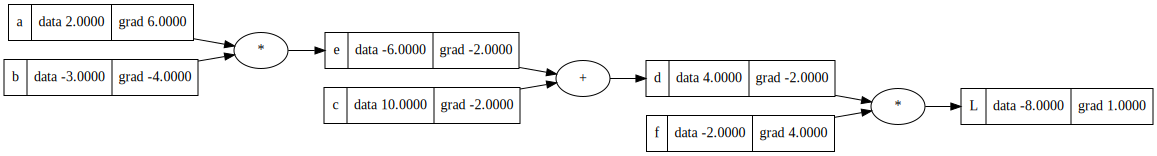

In [6]:
draw_dot(L)

In [7]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.881373, label='b')
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


In [8]:
o.backward()

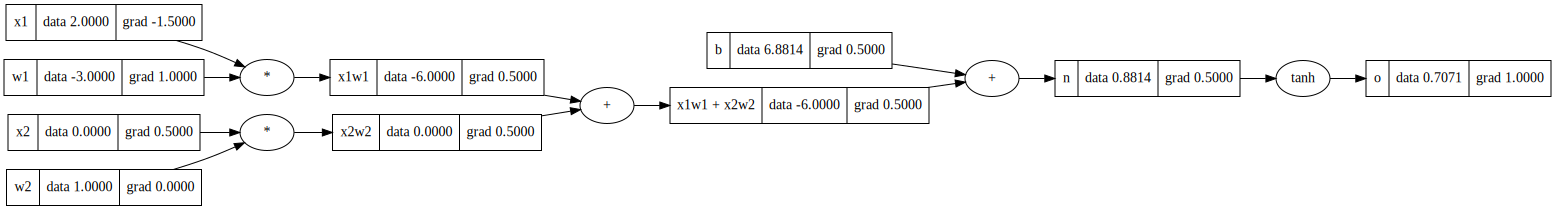

In [9]:
draw_dot(o)

In [10]:
import torch

x1 = torch.tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.tensor([1.0]).double(); w2.requires_grad = True
b = torch.tensor([6.8813]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
o.backward()
(x1.grad.item(),x2.grad.item(), w1.grad.item(), w2.grad.item())

(-1.5001561639694192, 0.5000520546564731, 1.0001041093129461, 0.0)

In [11]:
import random

class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def params(self):
    return self.w+[self.b]

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs

  def params(self):
    return [p for n in self.neurons for p in n.params()]

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin]+nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x[0] if len(x)==1 else x

  def params(self):
    return [p for l in self.layers for p in l.params()]

In [12]:
x = [2.0, 3.0]
n = MLP(2, [1])
n.params()

[Value(data=0.28325240453583644),
 Value(data=-0.842558604410431),
 Value(data=0.11873390515237103)]

In [13]:
xs = [[2.0, 3.0, -1.0],
      [3.0, -1.0, 0.5],
      [0.5, 1.0, 1.0],
      [1.0, 1.0, -1.0]]

ys = [1.0, -1.0, -1.0, 1.0]


In [14]:
for i in range(100):
  ypred = [n(x) for x in xs]
  loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
  if i == 0:
    print(f'{i} iteration loss is {loss.data}')
  for p in n.params():
    p.grad = 0.0
  loss.backward()
  for p in n.params():
    p.data += -0.1 * p.grad

loss.data


0 iteration loss is 9.827035223124128


1.0000868420327007

In [15]:
ypred

[Value(data=0.9999700138774853),
 Value(data=-0.7859298426540278),
 Value(data=-0.30193009356091827),
 Value(data=0.31665585932742824)]